In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import json
import os
import pandas as pd
import seaborn as sns
import glob
from natsort import natsorted
from scipy import stats
from sklearn.metrics import recall_score
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_auc_score, roc_curve
sns.set(style="whitegrid")
import matplotlib as mpl
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from matplotlib.ticker import PercentFormatter


In [3]:
def histogram(data):
    amnts, bins = np.histogram(data,bins=[0, 0.5, 1])
    return amnts[-1]/(np.sum(amnts))

def hist_pred(data, thresh=0.5):
    amnts, bins = np.histogram(data,bins=[0, thresh, 1])
    return int(amnts[0] < amnts[-1])

def process_fold(fold, aggregation_function=histogram, prediction_function=hist_pred, make_auc_plot=False):
    aucs = []
    labels = []
    confs = []
    scores = []
    for patient, data in fold.items():
        pred_key = 'predictions'
        label_key = 'label'
        if pred_key not in data:
            pred_key = 'val_predictions'
            label_key = 'val_label'
        if len(data[pred_key]) > 1:
            labels.append(data[label_key])
            confs.append(aggregation_function(data[pred_key]))
            score = int(data[label_key] == prediction_function(data[pred_key]))
            scores.append(score)
        else:
            continue
    auc = roc_auc_score(labels, confs)
    if make_auc_plot:
        fpr, tpr, thresh = roc_curve(labels, confs)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC={auc:.4f}')
        plt.legend()
    return auc, np.mean(scores)

In [4]:
def create_mega_fold(run_ids, root_dir='/home/colin/results_cov/', control=False):
    mega_fold = {}
    if control:
        root_dir = os.path.join(root_dir, 'control')
    for run_id in run_ids:
        files = glob.glob(os.path.join(root_dir, f'*{run_id}*.json'))
        assert len(files) == 1
        file = files[0]
        with open(file) as fp:
            all_data = json.load(fp)        
            test_fold = {patient: data for patient, data in all_data.items() if 'predictions' in data}
            for patient, data in test_fold.items():
                if patient in mega_fold:
                    mega_fold[patient]['predictions'] += data['predictions']
                else:
                    mega_fold[patient] = data
    return mega_fold

def denormalize_image(image, mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    image = image.clone()
    image = image * torch.tensor(std).view(3, 1, 1)
    image = image + torch.tensor(mean).view(3, 1, 1)
    return image.permute(1, 2, 0)

# LOADING MIL MODEL

In [5]:
import sys
sys.path.append('/home/colin/covid-blood/')
from config import get_config
from torchvision import transforms
from utils import setup_torch, get_covid_transforms, load_model
import wandb
from dataloader import load_all_patients, load_pbc_data
from models.imagenet import get_model
from models.multi_instance import AttentionModel, GatedAttentionModel, SimpleMIL
from mil_trainer import ClassificationTrainer
from torch import optim
import warnings
from tqdm import tqdm
import json

In [6]:
def get_unique_id(filename):
    return os.path.join(os.path.basename(os.path.dirname(filename)), os.path.basename(filename))

with open('/home/colin/wbc_class_1dr34rc5_v3.json') as fp:
    wbc_classification = json.load(fp)
    wbc_classification = {get_unique_id(key):value for key,value in wbc_classification.items()}

In [7]:
setup_torch(0, 1, 0)

In [8]:
# cell_types = ['basophil', 'ig', 'lymphocyte', 'platelet', 'neutrophil', 'eosinophil', 'erythroblast', 'monocyte', 'garbage']
cell_types = ['basophil', 'eosinophil', 'erythroblast', 'garbage', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
cell_types2 = ['Basophil', 'Eosinophil', 'Erythroblast', 'Smudged Cell', 'Immature Granulocyte', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

In [9]:
wbc_model = get_model('resnet50', len(cell_types), True).cuda()
wbc_model = load_model(wbc_model, '/home/colin/wbc_model_2021.pth').cuda()

In [27]:
mil_model(all_images)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [27, 224, 224] instead

0.5 blank


156it [00:00, 10815.60it/s]
39it [00:00, 9364.97it/s]
39it [00:00, 6793.38it/s]
  3%|▎         | 1/39 [00:00<00:04,  8.86it/s]

reading cache
TRAIN False
VAL False
TEST True


100%|██████████| 39/39 [00:20<00:00,  1.88it/s]

Hybrid ACC=0.7692307692307693
SIL ACC=0.7435897435897436
MIL ACC=0.7435897435897436


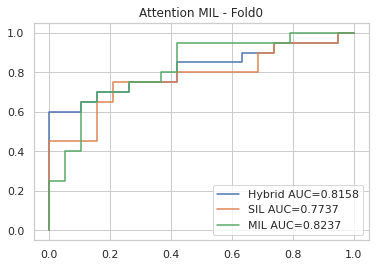

156it [00:00, 10743.68it/s]
39it [00:00, 9919.22it/s]
39it [00:00, 9172.25it/s]
  0%|          | 0/39 [00:00<?, ?it/s]

reading cache
TRAIN True
VAL False
TEST False


100%|██████████| 39/39 [00:22<00:00,  1.75it/s]


Hybrid ACC=0.6923076923076923
SIL ACC=0.7692307692307693
MIL ACC=0.5641025641025641


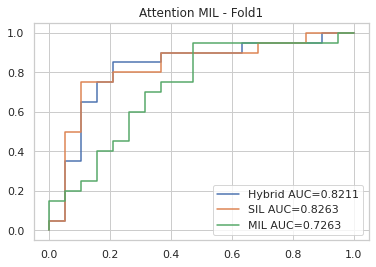

156it [00:00, 10774.11it/s]
39it [00:00, 9217.73it/s]
39it [00:00, 9771.68it/s]
  0%|          | 0/39 [00:00<?, ?it/s]

reading cache
TRAIN True
VAL False
TEST False


100%|██████████| 39/39 [00:21<00:00,  1.79it/s]

Hybrid ACC=0.7435897435897436
SIL ACC=0.7692307692307693
MIL ACC=0.6666666666666666


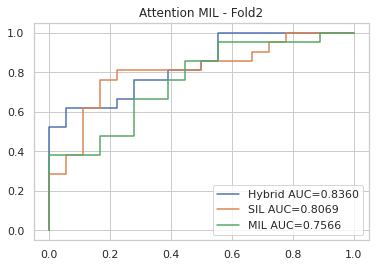

156it [00:00, 10829.38it/s]
39it [00:00, 9715.96it/s]
39it [00:00, 9545.86it/s]
  0%|          | 0/39 [00:00<?, ?it/s]

reading cache
TRAIN True
VAL False
TEST False


100%|██████████| 39/39 [00:21<00:00,  1.82it/s]


Hybrid ACC=0.8461538461538461
SIL ACC=0.8717948717948718
MIL ACC=0.6666666666666666


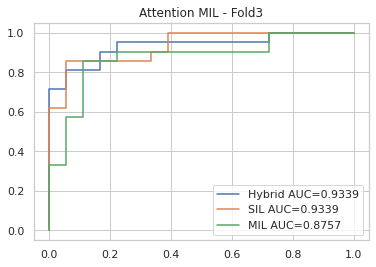

156it [00:00, 10399.43it/s]
39it [00:00, 8080.31it/s]
39it [00:00, 9102.32it/s]
  0%|          | 0/39 [00:00<?, ?it/s]

reading cache
TRAIN True
VAL False
TEST False


100%|██████████| 39/39 [00:19<00:00,  1.97it/s]

Hybrid ACC=0.8717948717948718
SIL ACC=0.8717948717948718
MIL ACC=0.6923076923076923


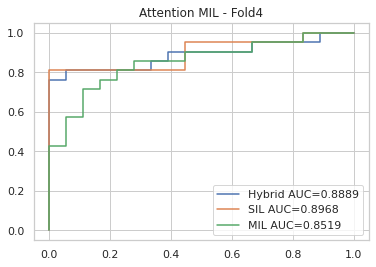

156it [00:00, 10534.21it/s]
39it [00:00, 11400.74it/s]
39it [00:00, 10012.72it/s]
  0%|          | 0/39 [00:00<?, ?it/s]

reading cache
TRAIN True
VAL False
TEST False


 87%|████████▋ | 34/39 [00:19<00:02,  1.76it/s]

In [ ]:
# cycle
mil_model_ids = {
    0: '3ro6u2m2',
    1: '3tgd0tuj',
    2: '2c4znl6l',
    3: '3nkokz7v',
    4: '49yim7v8',
    5: '1x8r67g4'
}

# # stable
# mil_model_ids = {
#     0: 'lci5jwwv',
#     1: '1cm25t7n',
#     2: '3fhpo32k',
#     3: '3la7hgld',
#     4: '36bz9ing',
#     5: '1jybznxf'
# }


sil_model_ids = {
    0: '1zjrjiku',
    1: '2om7nlu5',
    2: '1sddw8kt',
    3: '15jtunw1',
    4: '2pskiu0r',
    5: '3pgjwlo2'
}


folds = np.arange(0, 6)
data_transforms = get_covid_transforms(image_size=224, center_crop_amount=224)

for fold in folds[:]:
    mil_model_id = mil_model_ids[fold]
    # eventually make this a list
    sil_model_id = sil_model_ids[fold]
    # Load MIL model
    mil_model = SimpleMIL(
        backbone_name='densenet',
        num_classes=2,
        pretrained_backbone=False,
        instance_hidden_size=1024,
        hidden_size=1024
    )
    mil_model = load_model(mil_model, model_id=mil_model_id).cuda().eval()
    
    # Load the SIL results
    sil_fold = create_mega_fold([sil_model_id])
    # create loaders and make predictions for MIL model
    train_loader, val_loader, test_loader = load_all_patients(train_transforms=data_transforms['train'],
                                                              test_transforms=data_transforms['val'],
                                                              batch_size=1,
                                                              fold_number=fold,
                                                              group_by_patient=True,
                                                              weighted_sample=True,
                                                              random_sample=False,
                                                              extract_filenames=True)
    all_images = []
    all_labels = []
    all_preds = []
    all_wbc_preds = []
    all_attention = []
    group_size = 10000
    patient_ids = []
    
    all_count = 0
    all_weights = []
    for (filenames, images), labels in tqdm(test_loader):
        all_images = images.view(-1, 3, 224, 224)
        all_count += all_images.shape[0]
        groups = int(np.ceil(all_images.shape[0] / group_size))
        patient_classifications = []
        filename = filenames[0][0]
        patient_id = os.path.basename(filename).split('_')[0]
        try:
            int(patient_id)
        except:
            patient_id = os.path.basename(os.path.dirname(filename))
        patient_ids.append(patient_id)
        if patient_id not in sil_fold:
            raise RuntimeError()
        with torch.no_grad():
            for g in range(groups):
                start = g*group_size
                end = (g+1)*group_size
                inputs = all_images.view(-1, 3, 224, 224)[start:end].cuda()
                features = mil_model.backbone(inputs)
                attention = mil_model.attention(features)
                attention = torch.transpose(attention, 1, 0)
                attention_weights = F.softmax(attention, dim=1)
                aggregated_features = torch.mm(attention_weights, features)
                mil_classification = mil_model.mil_classifier(aggregated_features)
                patient_classifications.append(F.softmax(mil_classification, dim=-1)[0,1].cpu())
                all_attention.append(attention.cpu())
                all_weights.append(attention_weights.cpu())
            all_preds.append(np.median(patient_classifications))
            all_labels.append(labels)        
    
    hybrid_preds = []
    sil_preds = []
    mil_preds = []
    for patient_id, mil_pred in zip(patient_ids, all_preds):
        sil_pred = np.median(sil_fold[patient_id]['predictions'])
        sil_preds.append(sil_pred)
        mil_preds.append(mil_pred)
        final_pred = np.mean([sil_pred, mil_pred])
        hybrid_preds.append(final_pred)
    amnt  = 1
    plt.figure()
    plt.title(f"Attention MIL - Fold" + str(fold))
    # wsil_preds = []
    # for i in range(39):
    #     preds = torch.sum(all_weights[i][0] * F.softmax(all_sil_preds[i], dim=1)[:,1])
    #     wsil_preds.append(preds)

    wsil_preds = np.array(hybrid_preds)
    labels = np.array(all_labels)
    hybrid_auc = roc_auc_score(labels, wsil_preds)
    mil_auc = roc_auc_score(labels, mil_preds)
    sil_auc = roc_auc_score(labels, np.array(sil_preds))

    fpr, tpr, thresh = roc_curve(labels, wsil_preds)
    plt.plot(fpr, tpr, label=f'Hybrid AUC={hybrid_auc:.4f}')

    fpr, tpr, thresh = roc_curve(labels, np.array(sil_preds))
    plt.plot(fpr, tpr, label=f'SIL AUC={sil_auc:.4f}')


    fpr, tpr, thresh = roc_curve(labels, np.array(mil_preds))
    plt.plot(fpr, tpr, label=f'MIL AUC={mil_auc:.4f}')

    acc = np.mean(np.round(wsil_preds) == labels)
    print("Hybrid ACC=" + str(acc))
    acc = np.mean(np.round(np.array(sil_preds)) == labels)
    print("SIL ACC=" + str(acc))
    acc = np.mean(np.round(np.array(mil_preds)) == labels)
    print("MIL ACC=" + str(acc))

    plt.legend()
    plt.show()

0.46842105263157896


In [106]:
hybrid_preds = []
sil_preds = []
mil_preds = []
for patient_id, mil_pred in zip(patient_ids, all_preds):
    sil_pred = np.median(sil_fold[patient_id]['predictions'])
    sil_preds.append(sil_pred)
    mil_preds.append(mil_pred)
    final_pred = np.mean([sil_pred, mil_pred])
    hybrid_preds.append(final_pred)

Hybrid ACC=0.5128205128205128
SIL ACC=0.7435897435897436
MIL ACC=0.5128205128205128


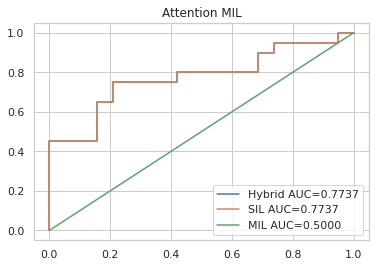

In [107]:
amnt  = 1
plt.figure()
plt.title(f"Attention MIL")
# wsil_preds = []
# for i in range(39):
#     preds = torch.sum(all_weights[i][0] * F.softmax(all_sil_preds[i], dim=1)[:,1])
#     wsil_preds.append(preds)

wsil_preds = np.array(hybrid_preds)
labels = np.array(all_labels)
hybrid_auc = roc_auc_score(labels, wsil_preds)
mil_auc = roc_auc_score(labels, mil_preds)
sil_auc = roc_auc_score(labels, np.array(sil_preds))

fpr, tpr, thresh = roc_curve(labels, wsil_preds)
plt.plot(fpr, tpr, label=f'Hybrid AUC={hybrid_auc:.4f}')

fpr, tpr, thresh = roc_curve(labels, np.array(sil_preds))
plt.plot(fpr, tpr, label=f'SIL AUC={sil_auc:.4f}')


fpr, tpr, thresh = roc_curve(labels, np.array(mil_preds))
plt.plot(fpr, tpr, label=f'MIL AUC={mil_auc:.4f}')

acc = np.mean(np.round(wsil_preds) == labels)
print("Hybrid ACC=" + str(acc))
acc = np.mean(np.round(np.array(sil_preds)) == labels)
print("SIL ACC=" + str(acc))
acc = np.mean(np.round(np.array(mil_preds)) == labels)
print("MIL ACC=" + str(acc))

plt.legend()

In [45]:
sil_pred

0.3951698839664459

In [26]:
mil_pred

0.00022381291

MISL ACC=0.8461538461538461


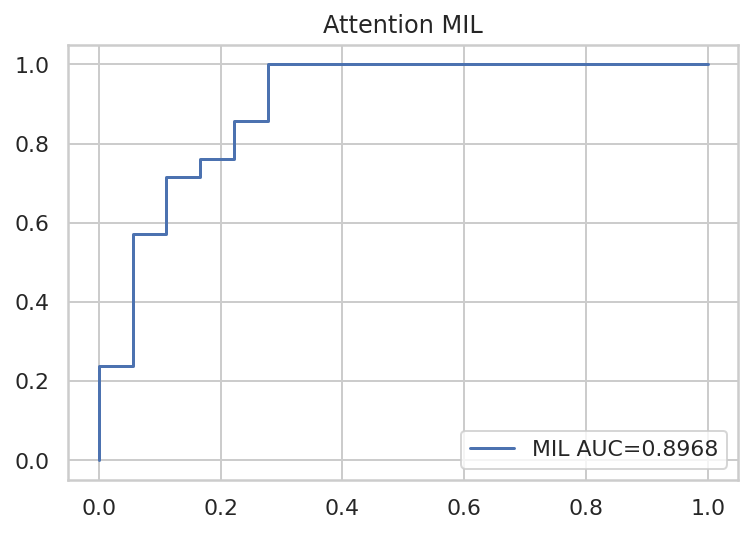

In [113]:
amnt  = 1
plt.figure()
plt.title(f"Attention MIL")
# wsil_preds = []
# for i in range(39):
#     preds = torch.sum(all_weights[i][0] * F.softmax(all_sil_preds[i], dim=1)[:,1])
#     wsil_preds.append(preds)

wsil_preds = np.array(all_preds)
labels = np.array(all_labels)
auc = roc_auc_score(labels, wsil_preds)
fpr, tpr, thresh = roc_curve(labels, wsil_preds)

plt.plot(fpr, tpr, label=f'MIL AUC={auc:.4f}')

acc = np.mean(np.round(wsil_preds) == labels)
print("MISL ACC=" + str(acc))
plt.legend()

In [99]:
all_preds

[0.018474935]

In [100]:
all_labels

[tensor([1])]

In [92]:
F.softmax(mil_classification, dim=-1)[0,0].cpu()

tensor(0.4309)

In [95]:
torch.stack(patient_classifications).cpu().view(groups)

tensor([0.0717, 0.0052, 0.0104, 0.0700, 0.0099, 0.0146, 0.0100, 0.0235, 0.0622,
        0.0127, 0.0323, 0.0268, 0.0209, 0.0073])

In [14]:
unique_ids = [get_unique_id(f[0]) for f in filenames]

In [17]:
with torch.no_grad():
    wbc_preds = wbc_model(all_images[3:4])

In [18]:
cell_types[np.argmax(wbc_preds.numpy(), axis=-1)[0]]

'platelet'

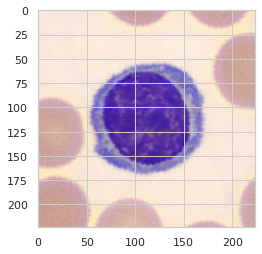

In [19]:
plt.imshow(denormalize_image(all_images[3]))

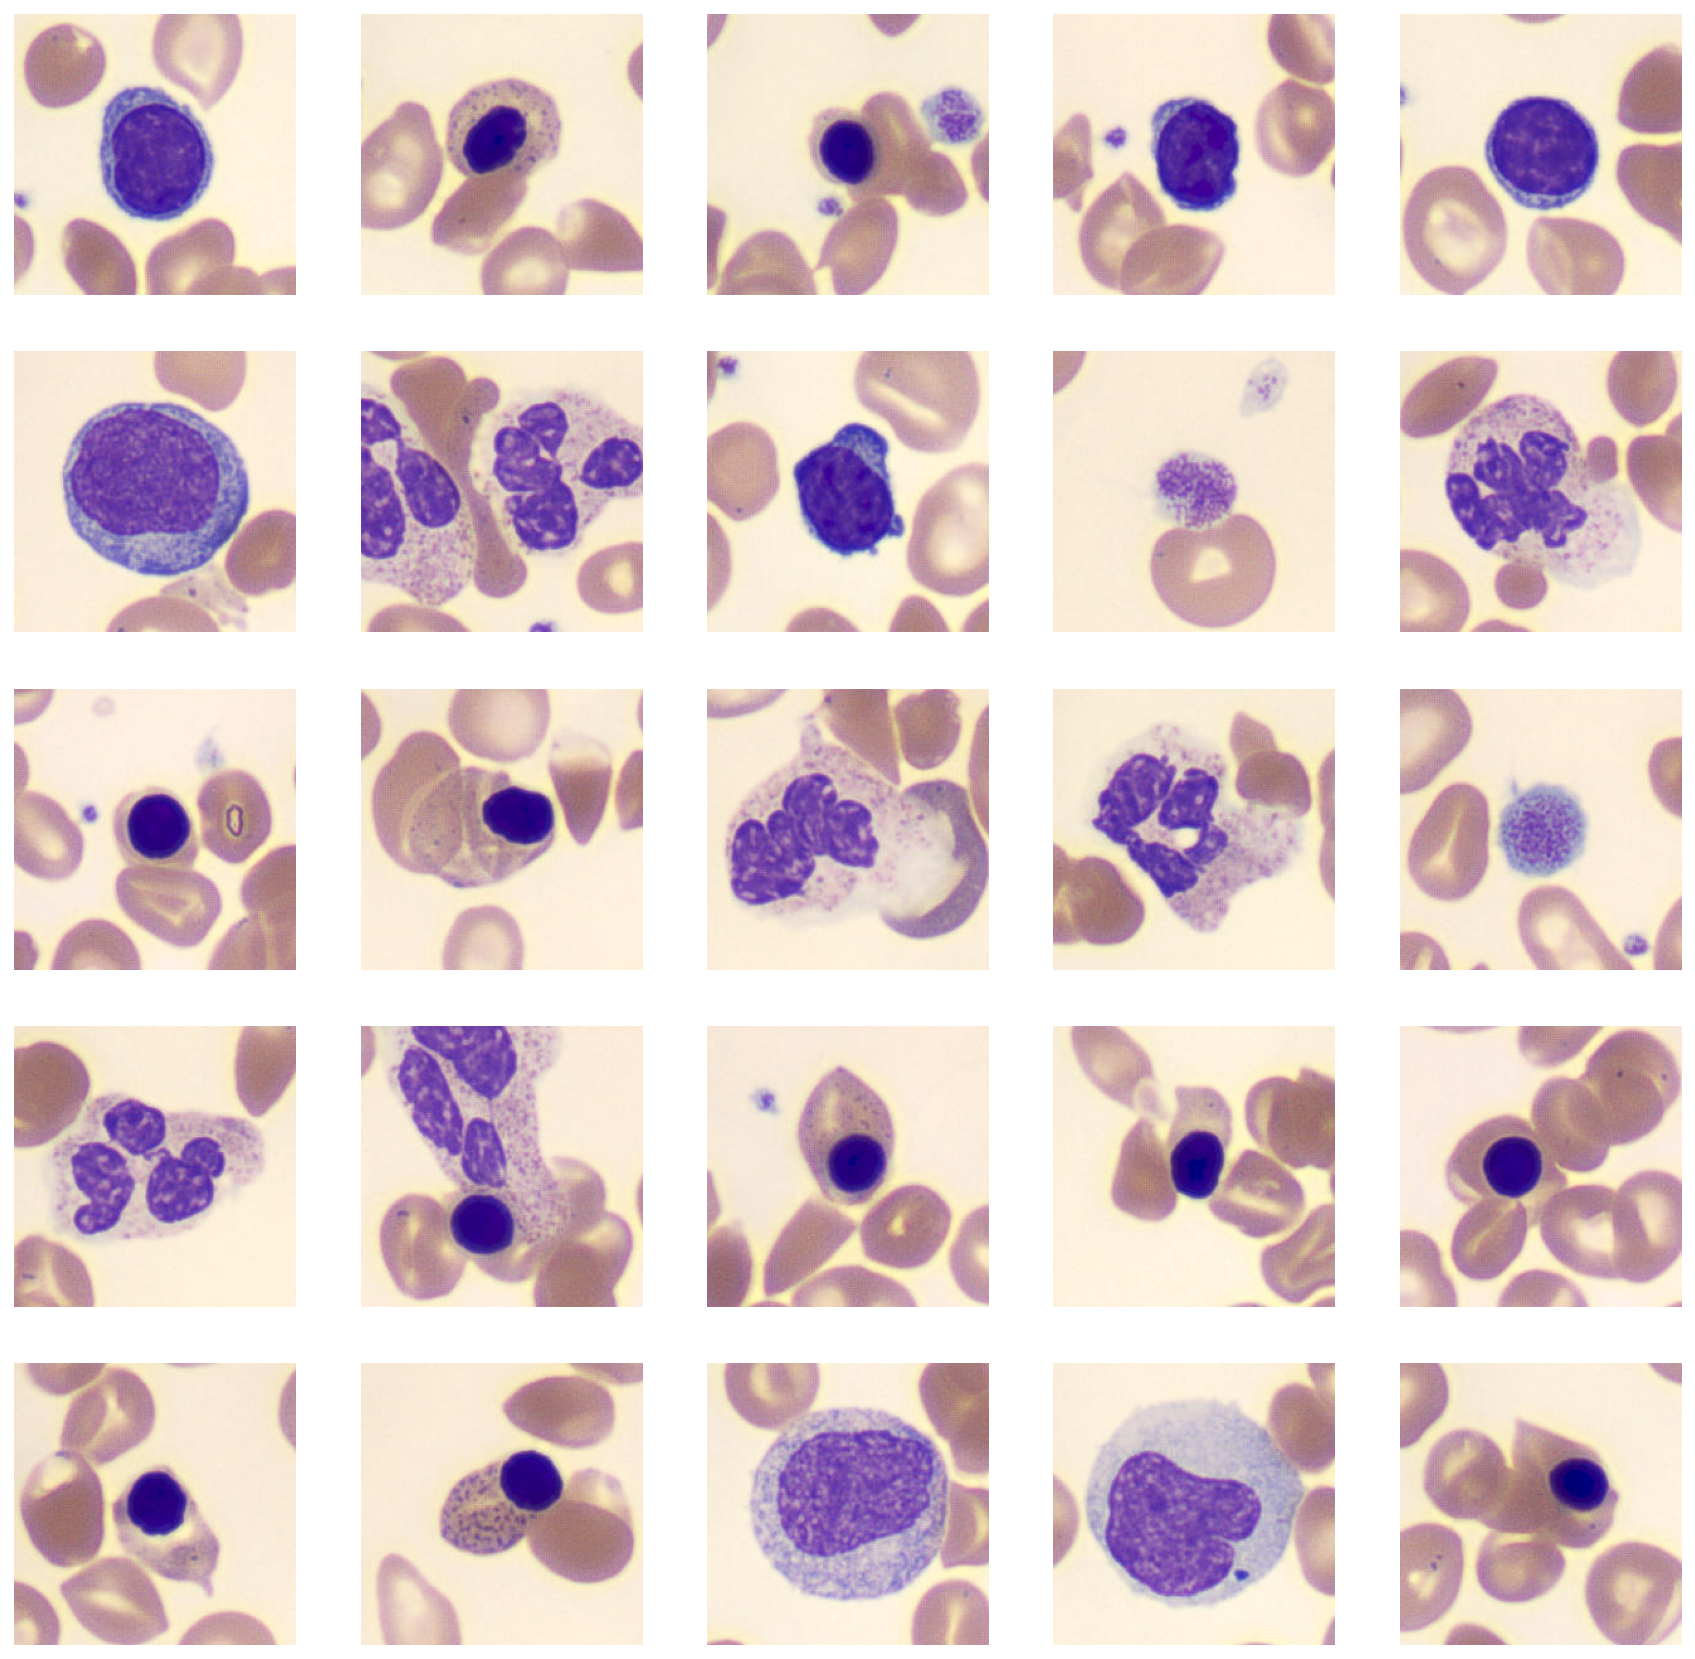

In [65]:
subsampled_inds = np.random.choice(np.arange(0, all_images.shape[0]), size=25, replace=False).tolist()
# top 13
# bottom 12
unique_ids = [get_unique_id(f[0]) for f in filenames]
wbc_types = np.argmax(wbc_preds.numpy(), axis=-1)
all_inds = sorted(np.arange(0, all_images.shape[0]).tolist(), key=lambda x: -attention[0,x])
# inds = all_inds[0:13] + all_inds[-12:]
top_inds = all_inds[0:25]

bottom_inds = all_inds[-25:]


middle = int(len(all_inds)//2)
middle_inds = all_inds[middle - 12:middle +13]

# inds = top_inds
# inds = middle_inds
inds = bottom_inds
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
counter = 0
for si in inds:
    weight = attention[0,si]
    pred_type = cell_types2[wbc_types[si]]
    image = denormalize_image(all_images[si])
    ax = axs[counter //5, counter % 5]
    ax.imshow(image)
    ax.axis('off')
#     ax.set_title(f"{pred_type}:\n {weight:.3f}")
    counter += 1

In [28]:
weights_by_cell_type = {cell_type:[] for cell_type in cell_types2}
all_scores = []
neg_types = []
pos_types = []
all_types = []
def score_to_perc(score):
    return np.sum(np.array(all_scores) < score) / len(all_scores)

for i in range(len(all_attention)):
    for j in range(len(all_wbc_preds[i])):
        score = float(all_attention[i][0,j])
        all_scores.append(score)
pos_percs = []
neg_percs = []
all_percs = []    
weights_by_cell_type_pos = {cell_type:[] for cell_type in cell_types2}
weights_by_cell_type_neg = {cell_type:[] for cell_type in cell_types2}
for i in range(len(all_attention)):
    lab = int(all_labels[i])
    for j in range(len(all_wbc_preds[i])):
        pred_type = cell_types2[np.argmax(all_wbc_preds[i][j].numpy())]
        score = float(all_attention[i][0,j])
        perc = score_to_perc(score)
        all_percs.append(perc)
        
        weights_by_cell_type[pred_type].append(perc)
        if lab == 0:
            neg_percs.append(perc)
            neg_types.append(pred_type)
            weights_by_cell_type_neg[pred_type].append(perc)
        else:
            pos_percs.append(perc)
            pos_types.append(pred_type)
            weights_by_cell_type_pos[pred_type].append(perc)
        all_types.append(pred_type)

In [33]:
from natsort import natsorted

In [36]:
all_types, all_percs = zip(*natsorted(zip(all_types, all_percs), key=lambda x: x[0]))
pos_types, pos_percs = zip(*natsorted(zip(pos_types, pos_percs), key=lambda x: x[0]))
neg_types, neg_percs = zip(*natsorted(zip(neg_types, neg_percs), key=lambda x: x[0]))

In [37]:
import pandas as pd

In [38]:
data_frame_data = {
    'Cell Type': all_types,
    'Score Percentile': all_percs
}

data_frame_data_pos = {
    'Cell Type': pos_types,
    'Score Percentile': pos_percs
}

data_frame_data_neg = {
    'Cell Type': neg_types,
    'Score Percentile': neg_percs
}

In [39]:
dataframe = pd.DataFrame(data_frame_data)
dataframe_pos = pd.DataFrame(data_frame_data_pos)
dataframe_neg = pd.DataFrame(data_frame_data_neg)

In [133]:
sns.set()

In [40]:
mpl.rcParams['figure.dpi'] = 144

Text(0.5, 1.0, 'COVID Positive Patients')

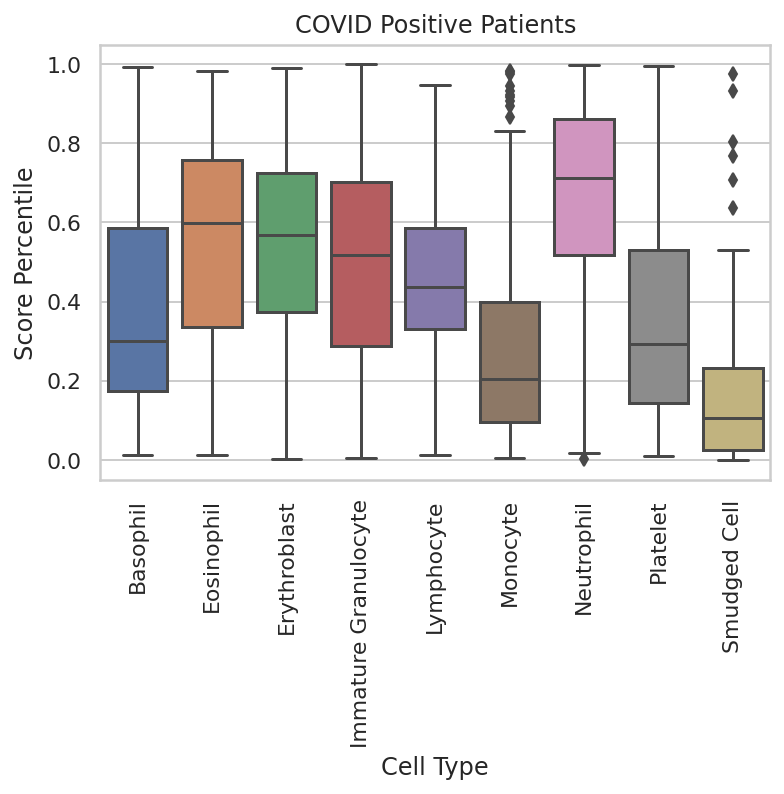

In [44]:
g = sns.boxplot(y=dataframe_pos['Score Percentile'], x=dataframe_pos['Cell Type'], orient='v')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("COVID Positive Patients")

Text(0.5, 1.0, 'COVID Negative Patients')

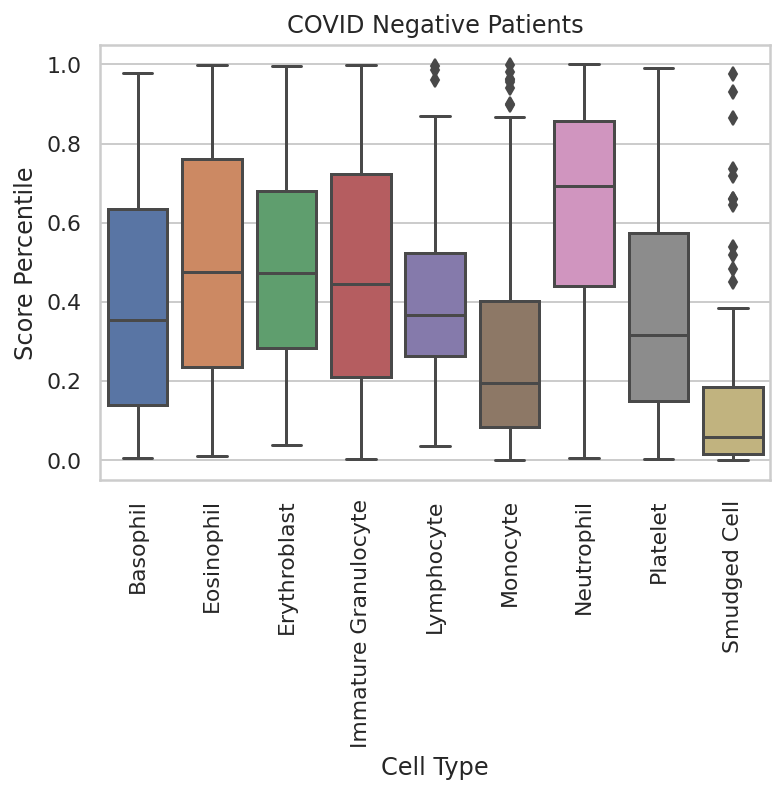

In [45]:
g = sns.boxplot(y=dataframe_neg['Score Percentile'], x=dataframe_neg['Cell Type'], orient='v')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("COVID Negative Patients")

Text(0.5, 1.0, 'All Patients')

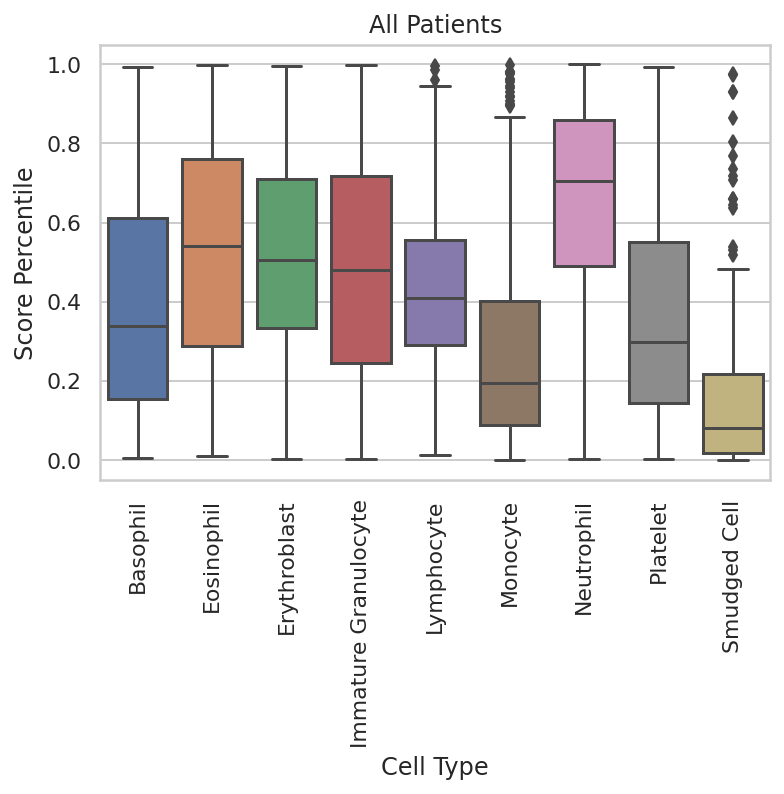

In [46]:
g = sns.boxplot(y=dataframe['Score Percentile'], x=dataframe['Cell Type'], orient='v')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("All Patients")

In [ ]:
plt.boxplot()

In [76]:
box_data = [weights_by_cell_type[c] for c in cell_types]

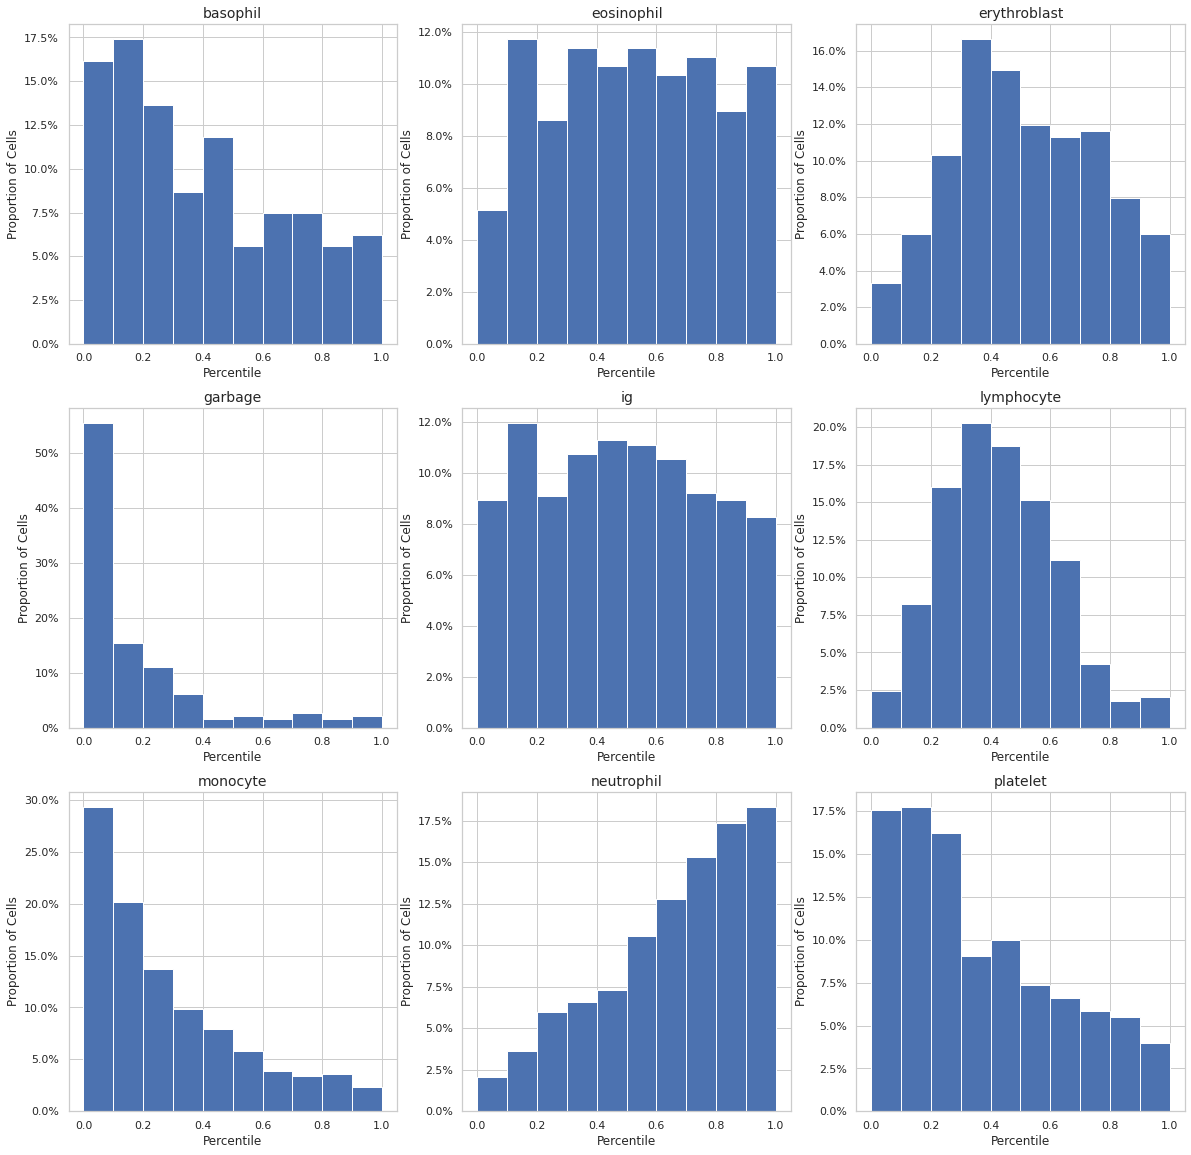

In [66]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
bins = np.linspace(0, 1, 11)
bar_locations = np.linspace(0.05, 0.95, 10)
for i in range(9):
    ax = axs[i//3, i%3]
    cell_type = cell_types[i]
    ax.set_title(cell_type, fontsize=14)
    scores = weights_by_cell_type[cell_type]
    counts, edges = np.histogram(scores, bins)
#     ax.hist(weights_by_cell_type[cell_type], bins=bins, density=False)
    ax.bar(bar_location, counts/np.sum(counts), width=0.1)
    ax.set_xlabel("Percentile")
    ax.set_ylabel("Proportion of Cells")
#     ax.set_ylim(0, 0.5)
    ax.yaxis.set_major_formatter(PercentFormatter(1))

In [24]:
image = denormalize_image(all_images[1])

In [25]:
cell_types[np.argmax(F.softmax(wbc_preds[1], dim=0).numpy())]

'monocyte'

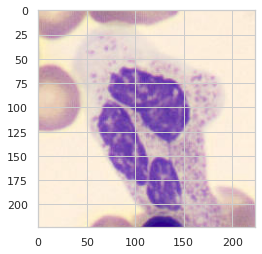

In [26]:
plt.imshow(image)

In [114]:
sample_weights = attention_weights.view(-1).numpy()

In [108]:
sample_weights.shape

(135,)

Text(0.5, 1.0, 'Weight Distribution - Sample 2')

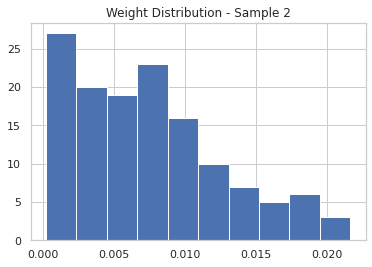

In [117]:
plt.hist(sample_weights)
plt.title("Weight Distribution - Sample 2")

MISL ACC=0.7692307692307693


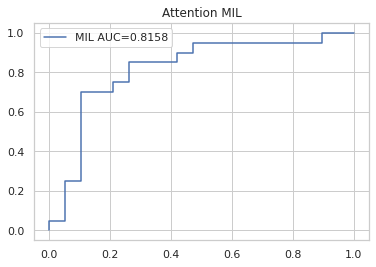

In [94]:
amnt  = 1
plt.figure()
plt.title(f"Attention MIL")
wsil_preds = []
for i in range(39):
    preds = torch.sum(all_weights[i][0] * F.softmax(all_sil_preds[i], dim=1)[:,1])
    wsil_preds.append(preds)

wsil_preds = np.array(wsil_preds)
labels = np.array(all_labels)
auc = roc_auc_score(labels, wsil_preds)
fpr, tpr, thresh = roc_curve(labels, all)

plt.plot(fpr, tpr, label=f'MIL AUC={auc:.4f}')

acc = np.mean(np.round(wsil_preds) == labels)
print("MISL ACC=" + str(acc))
plt.legend()

In [101]:
test = [np.median(F.softmax(sil_preds, dim=-1)[:,1].numpy()) for sil_preds in all_sil_preds]

In [102]:
roc_auc_score(labels, test)

0.8157894736842106

In [99]:
labels = np.array(all_labels)
confs = [F.softmax(p, dim=-1)[0,1] for p in all_preds]

MIL ACC=0.6923076923076923


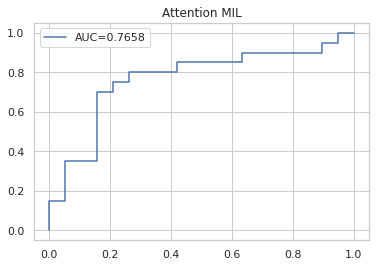

In [100]:
auc = roc_auc_score(labels, confs)
fpr, tpr, thresh = roc_curve(labels, confs)
plt.figure()
plt.title("Attention MIL")
plt.plot(fpr, tpr, label=f'AUC={auc:.4f}')
plt.legend()

acc = np.mean(np.round(confs) == labels)
print("MIL ACC=" + str(acc))

In [14]:
baseline_runs_s = baseline_runs[0:1]

In [15]:
mega_fold = create_mega_fold(baseline_runs_s)

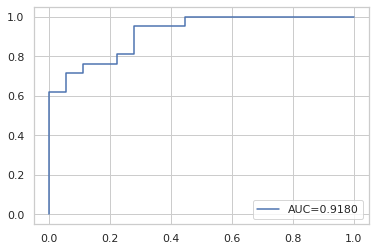

In [25]:
baseline_auc, baseline_acc = process_fold(create_mega_fold(f3_runs[0:1]), make_auc_plot=True)

In [89]:
fold = 0

In [90]:
_, _, test_loader_bag = load_all_patients(train_transforms=data_transforms['train'],
                                                              test_transforms=data_transforms['val'],
                                                              batch_size=1,
                                                              fold_number=fold,
                                                              group_by_patient=True,
                                                              weighted_sample=True,
                                                              random_sample=False,
                                                              extract_filenames=True)
_, _, test_loader_image = load_all_patients(train_transforms=data_transforms['train'],
                                                              test_transforms=data_transforms['val'],
                                                              batch_size=1,
                                                              fold_number=fold,
                                                              group_by_patient=False,
                                                              weighted_sample=True,
                                                              random_sample=False,
                                                              extract_filenames=True)

156it [00:00, 9975.48it/s]
39it [00:00, 9603.58it/s]
39it [00:00, 8885.75it/s]
156it [00:00, 4921.71it/s]
39it [00:00, 7206.07it/s]
39it [00:00, 6223.00it/s]

reading cache
reading cache


In [100]:
order_images = set()
order_bags = set()

for (image, filename), label  in test_loader_image:
    filename = filename[0]
    order_og = os.path.basename(os.path.dirname(filename))
    order = os.path.basename(filename).split('_')[0]
    try:
        int(order)
    except:
        order = os.path.basename(os.path.dirname(filename))
    if order_og != order:
        raise RuntimeError()
    order_images.add(order)
# for (filenames, bag), label in test_loader_bag:
#     order_number = os.path.basename(os.path.dirname(filenames[0][0]))
#     assert order_number not in order_bags
#     order_bags.add(order_number)


RuntimeError: 

In [103]:
filename

'/hddraid5/data/colin/covid-data/aug_24/COVID Research Images/August 5 2020-Reuploaded/10051879530/10051879005_110.jpg'

In [101]:
order

'10051879005'

In [102]:
order_og

'10051879530'

In [95]:
for o in order_images:
    if o not in order_bags:
        print(o)